In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.4 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/BERT_Capstone/BertModel.py /content
!cp /content/drive/MyDrive/BERT_Capstone/BertTrainer.py /content
!cp /content/drive/MyDrive/BERT_Capstone/CrimeVsNonCrime2.xlsx /content

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

from BertModel import BertClassifier
from BertTrainer import Custom_Trainer

In [6]:
MAX_TOKEN_LENGTH = 64
EPOCHS = 3
LR = 1e-5
DECAY = 1e-6
BATCH_SIZE = 16

LABEL_COLUMN = 'label'
get_word_count = False
column_list = ['text', 'label', 'word_count']
labels = {'Crime':0,
          'Non-crime':1}

In [ ]:
trainer = Custom_Trainer(EPOCHS, BATCH_SIZE, labels, LABEL_COLUMN, LR, DECAY)

In [7]:
# train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")

df = pd.read_excel("/content/CrimeVsNonCrime2.xlsx")
print(df.describe())
print(f"All entries unique: {df['Title'].nunique()==df.shape[0]}")
print(f"Null cells: {df.isnull().sum().sum()}")

                                                    Title  Label
count                                               68934  68934
unique                                              68393      2
top     Don’t want to play the friend who drives hero ...  Crime
freq                                                    2  35334
All entries unique: False
Null cells: 0


In [8]:
df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
print(f"All entries unique: {df['Title'].nunique()==df.shape[0]}")

All entries unique: True


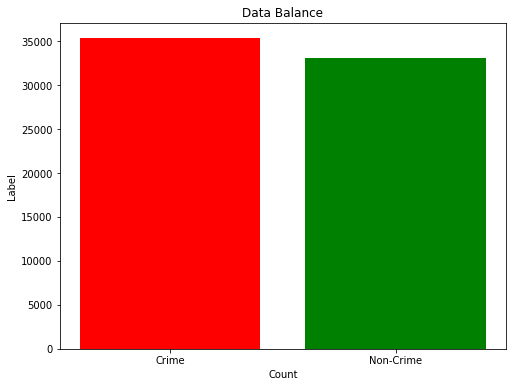

In [9]:
if not LABEL_COLUMN in column_list:
    raise Exception("Label name in 'filtered_df' do not match with LABEL_COLUMN. Check the label columns and add them to LABEL_COLUMN")

filtered_df = pd.DataFrame(columns=column_list)

filtered_df[LABEL_COLUMN] = (pd.Categorical(df['Label']).codes).astype(int)
label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

Average Word count: 12.098899010132616


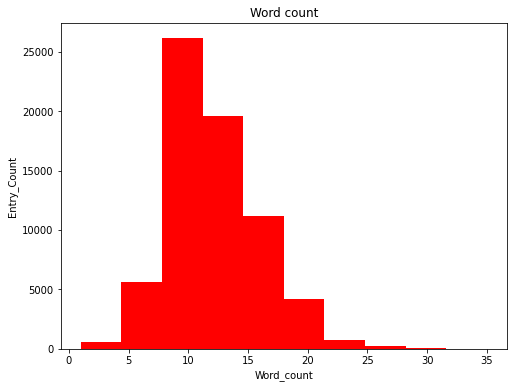

In [10]:
# text_list = []
# word_count = []

# for entry in train_df['Title']:
#     new_text = re.sub("[^a-zA-Z ]", " ", entry)
#     new_text = new_text.lower().split()
#     word_count.append(len(new_text))
#     new_text = ' '.join(new_text)
#     text_list.append(new_text)

# filtered_df['text'] = text_list
# filtered_df['word_count'] = word_count

filtered_df['text'] = trainer.preprocess_data_x(df['Title'], get_word_count=get_word_count)

if get_word_count:
  plt.figure(figsize=(8, 6))
  print(f"Average Word count: {np.average(filtered_df['word_count'])}")
  plt.hist(filtered_df['word_count'],color='red')
  plt.title('Word count')
  plt.xlabel('Word_count')
  plt.ylabel('Entry_Count')
  plt.show()

In [13]:
bert_df = filtered_df.drop(columns=['word_count']) if get_word_count else filtered_df.copy()

df_train, df_val, df_test = np.split(bert_df.sample(frac=1, random_state=42), 
                                     [int(.8*len(bert_df)), int(.9*len(bert_df))])

print(f"Train Size: {len(df_train)}\nValidation Size: {len(df_val)}\nTest Size: {len(df_test)}")

Train Size: 54714
Validation Size: 6839
Test Size: 6840


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertClassifier(bert_model)
              
trainer.train(model, df_train, df_val, tokenizer)

 99%|█████████▉| 3400/3420 [1:19:43<00:28,  1.41s/it]

In [ ]:
# #torch.save(model, './Bert_Weights/Bert_E2_896')
# torch.save(model.state_dict(), './Bert_Weights/Bert_E2_896.pt')
# new_model = BertClassifier(bert_model)
# new_model.load_state_dict(torch.load('./Bert_Weights/Bert_E2_896.pt'))
# evaluate(new_model, df_test, BATCH_SIZE)

<All keys matched successfully>

In [ ]:
final_acc = trainer.evaluate(model, df_test, tokenizer)

Test Accuracy:  0.877
